In [1]:
import numpy as np
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from scipy import special
plt.rcParams['figure.figsize'] = [14, 11]

In [2]:
path = 'CIV/FAIRALL9/CIV.bin3.linespec' 
wl, fl, fe, ctn = np.loadtxt(path).transpose()  # is there a line spread function in this new format ?
fln = fl / ctn
fen = fe / ctn


lsf = np.loadtxt('FAIRALL9/CIV.lsf') 

In [3]:
wl1, f1, gamma1, elem, state = (1548.187, 0.19, 0.00324, 'C', 'IV')
wl2, f2, gamma2, elem, state = (1550.772, 0.0952, 0.00325, 'C', 'IV')

In [4]:
def V2Wave(v, wlr):
    return ((v * (1e-13 *wlr) / 3e5) + (wlr * 1e-13))*1e13

def Wave2V(wl, wlr):
    return ((wl / 1e13) - (wlr * 1e-13)) * 3e5 / (1e-13 *wlr)

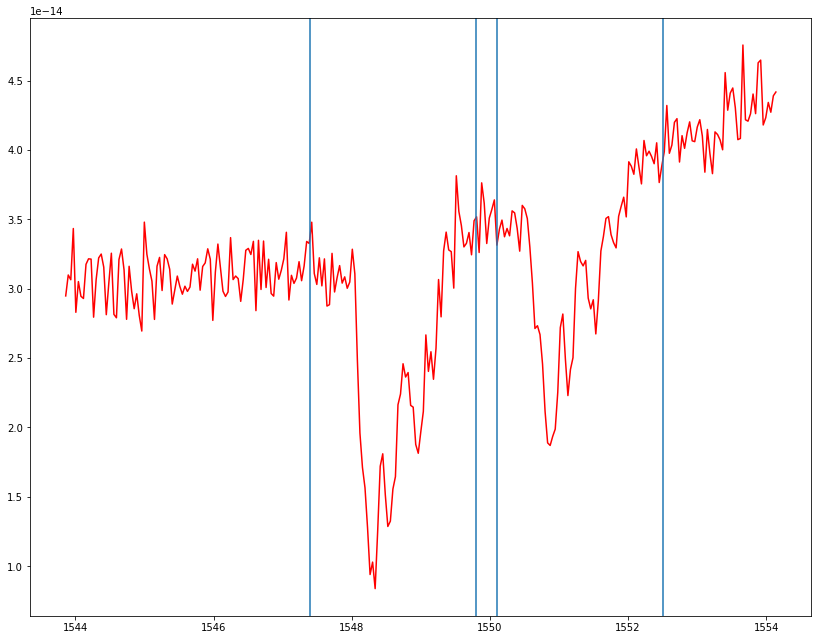

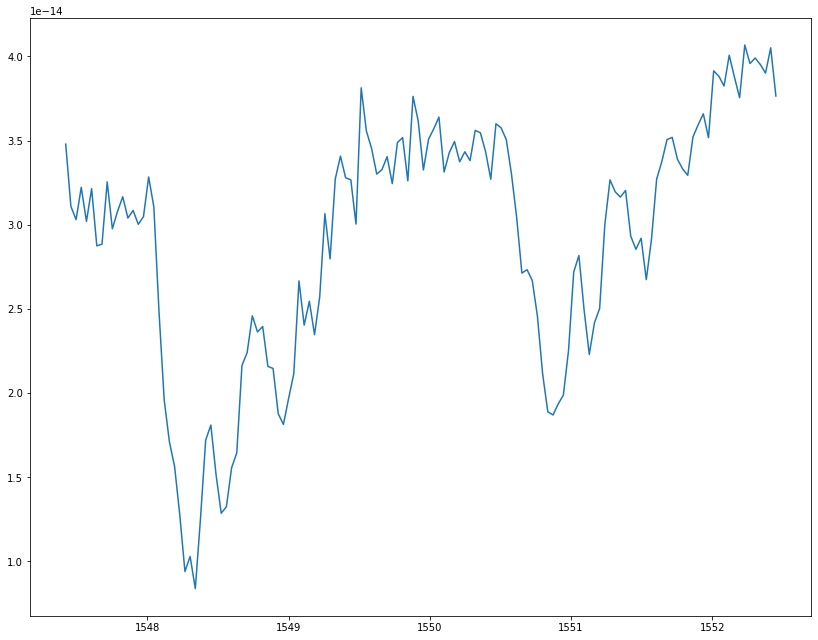

97 161 170 235


In [5]:
plt.plot(wl, fl, '-r')
plt.axvline(1547.4)
plt.axvline(1549.8)
diff = 1549.8 - 1547.4
plt.axvline(1550.1)
plt.axvline(1550.1 + diff)
plt.show()

min1 = np.min(np.where(wl > 1547.4))
max1 = np.max(np.where(wl < 1549.8))

diff = 1549.8 - 1547.4

min2 = np.min(np.where(wl > 1550.1))
max2 = np.max(np.where(wl < 1550.1 + diff))


plt.plot(wl[min1:max2], fl[min1:max2])
plt.show()

print(min1, max1, min2, max2)



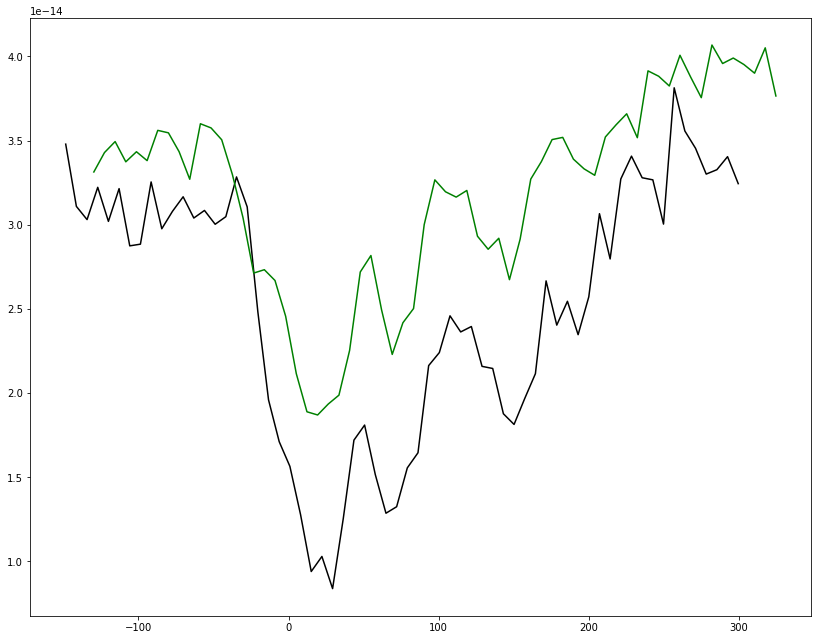

In [6]:
v1 = Wave2V(wl[min1:max1], wl1)
v2 = Wave2V(wl[min2:max2], wl2)

fl1 = fl[min1:max1]
fl2 = fl[min2:max2]

ctn1 = ctn[min1:max1]
ctn2 = ctn[min2:max2]

fe1 = fe[min1:max1]
fe2 = fe[min2:max2]

fn1 = fl1 / ctn1
fn2 = fl2 / ctn2

fne1 = fe1 / ctn1
fne2 = fe2 / ctn2

plt.plot(v1, fl[min1:max1], '-k')
plt.plot(v2, fl[min2:max2], '-g')
plt.show()

In [7]:
def model(p0):
    m1 = np.ones(v1.shape)
    m2 = np.ones(v2.shape)
    Ncomp = len(p0)//3
    for comp_i in range(Ncomp):
        N, b, vc = p0[comp_i*3: comp_i*3+3]
        m1 = m1*vline(v1, [b/1.414, gamma1, N2tau(10**N, wl1, f1), vc, 1])
        m2 = m2*vline(v2, [b/1.414, gamma2, N2tau(10**N, wl2, f2), vc, 1])

    m1 = convolve(m1, lsf)
    m2 = convolve(m2, lsf)
    return m1, m2

def fitting(p0):
    m1, m2 = model(p0)
    chi1 = (fn1 - m1) / fne1
    chi2 = (fn2 - m2) / fne2

    chi1 = chi1[(v1 < 200) & (v1 > -200)]
    chi2 = chi2[(v2 < 200) & (v2 > -200)]

    return np.append(chi1, chi2)

def convolve(model, lsf):
    Nlsf = len(lsf) // 2
    ext_model = np.append(np.ones(Nlsf)*model[0], model)
    ext_model = np.append(ext_model, np.ones(Nlsf)*model[-1])
    cmodel = np.convolve(ext_model, lsf, 'valid')
    return cmodel

def N2tau(N, wlr, f):
    tau = N * 2.654e-15 * f * wlr
    return tau

def Voigt(x, x0, sigma, gamma):
    '''
    x should be an array.
    sigma is the Doppler parameter.
    gamma is the Gaussian sigma.
    x0 is the center position.
    '''
    z = ((x-x0) + 1j * abs(gamma)) / abs(sigma) / 2**0.5

    return (special.wofz(z)).real/abs(sigma)/(2*np.pi)**0.5

def vline(x, p):
    '''
    p = [sigma, gamma, tau, v0, covering_factor]
    saturated_factor is a newly defined parameter to describe the thermal radiation varying in 0 to 1.
    The simplified model is c_f * exp(-tau) + (1-c_f).
    '''
    x = np.array(x)
    pro = abs(p[2]) * Voigt(x, p[3], p[0], abs(p[1]))

    return abs(p[4]) * np.exp(-pro) + (1 - abs(p[4]))


In [8]:
x0 = [13.5, 20.3, -20] + [13.5, 20.3, 40] + [13, 20.3, 150] + [13, 20.3, 170]
p0, cov, a, b, c = leastsq(fitting, x0, full_output=1)

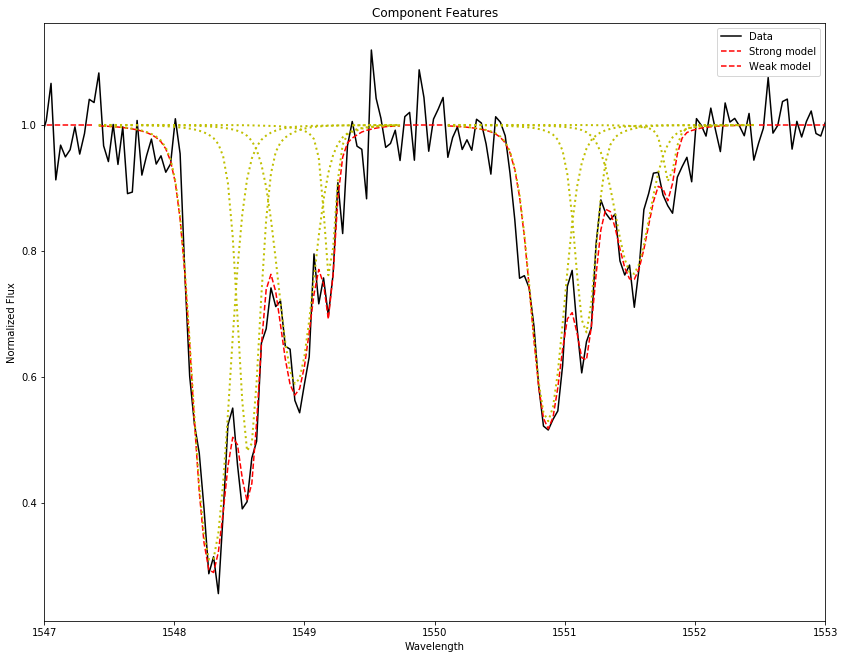

In [9]:
def plot_model(p0):
    m1, m2 = model(p0)
    
    plt.plot(wl, fln, '-k', label='Data')
    plt.plot(wl[min1:max1], m1, '--r', label='Strong model')
    plt.plot(wl[min2:max2], m2, '--r', label='Weak model')
    plt.plot(wl[0:min1], [1] * len(wl[0:min1]), '--r')
    plt.plot(wl[max1:min2], [1] * len(wl[max1:min2]), '--r')
    plt.plot(wl[max2:len(wl)-1], [1] * len(wl[max2:len(wl)-1]), '--r')
    Ncomp = len(p0)//3
    for comp_i in range(Ncomp):
        N, b, vc = p0[comp_i*3: comp_i*3+3]
        m1 = vline(v1, [b/1.414, gamma1, N2tau(10**N, wl1, f1), vc, 1])
        m2 = vline(v2, [b/1.414, gamma2, N2tau(10**N, wl2, f2), vc, 1])

        m1 = convolve(m1, lsf)
        m2 = convolve(m2, lsf)
        
        plt.plot(wl[min1:max1], m1, 'y:', lw=2)
        plt.plot(wl[min2:max2], m2, 'y:', lw=2)
    plt.legend()
    plt.xlim(1547, 1553)
    plt.title('Component Features')
    plt.xlabel('Wavelength')
    plt.ylabel('Normalized Flux')
    plt.show()
    
plot_model(p0)

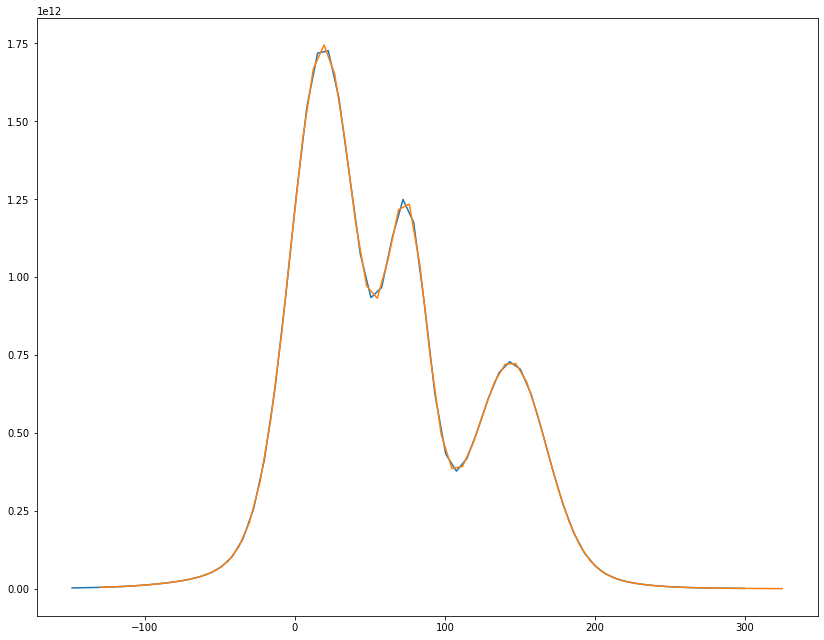

In [10]:
def make_features(p0, v1, v2, gamma1, gamma2, lsf):
    length = len(p0) // 4
    Ns_tot = 0
    Nw_tot = 0 
    for i in range(length):
        Ns_tot += 10**(p0[3 * i])*Voigt(v1, p0[2 + 3*i], p0[1 + 3*i]/np.sqrt(2), gamma1)
        Nw_tot += 10**(p0[3 * i])*Voigt(v2, p0[2 + 3*i], p0[1 + 3*i]/np.sqrt(2), gamma2)
    Ns_c = convolve(Ns_tot, lsf)
    Nw_c = convolve(Nw_tot, lsf)
    return Ns_c, Nw_c

N1, N2 = make_features(p0, v1, v2, gamma1, gamma2, lsf)
plt.plot(v1, N1)
plt.plot(v2, N2)

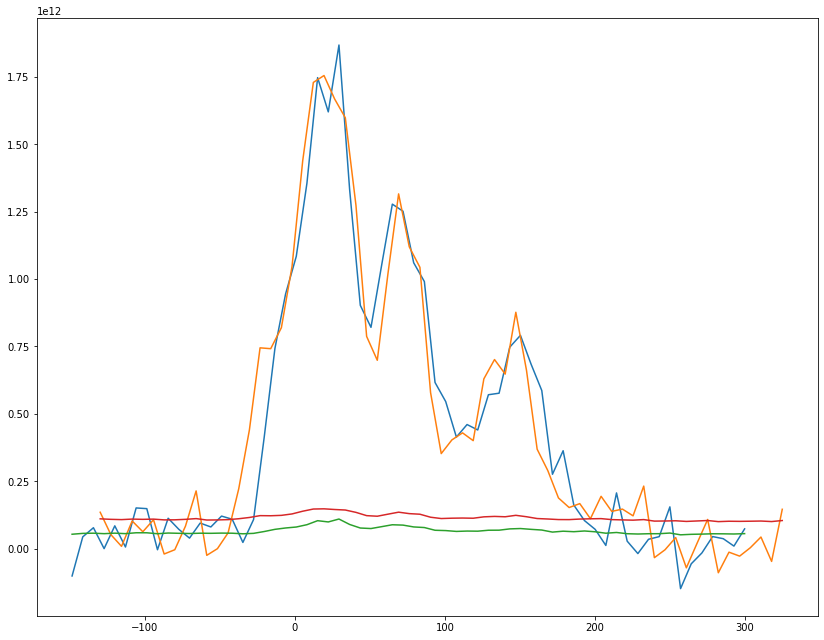

In [11]:
def add_residual(Ns_c, Nw_c, p0, wl1, wl2, f1, f2):
    m1, m2 = model(p0)
    r1 = fn1 / m1
    r2 = fn2 / m2
    N_r_s = N_v(r1, wl1, f1)
    N_r_w = N_v(r2, wl2, f2)
    Ns_c += N_r_s
    Nw_c += N_r_w
    return Ns_c, Nw_c

def N_v(fn, wlr, f):
    return -np.log(fn)/wlr/f/2.654e-15

def nfle2Nev(nfl, nfle, f, wlr):      # calculte error in the column density 
    Nev = nfle/nfl / 2.654e-15/f/wlr
    return Nev     

N1r, N2r = add_residual(N1, N2, p0, wl1, wl2, f1, f2)
Ne1 = nfle2Nev(fn1, fne1, f1, wl1)
Ne2 = nfle2Nev(fn2, fne2, f2, wl2)

plt.plot(v1, N1r)
plt.plot(v2, N2r)
plt.plot(v1, Ne1)
plt.plot(v2, Ne2)

In [12]:
def make_same_length(a1, a2):
    a1 = np.array(a1)
    a2 = np.array(a2)
    while(len(a1) != len(a2)):
        if (len(a1) < len(a2)):
            l = a2.tolist()
            l.pop(-1)
            a2 = np.array(l)
        else :
            l = a1.tolist()
            l.pop(-1)
            a1 = np.array(l)
    return a1, a2

v1, v2 = make_same_length(v1, v2)
N1, N2 = make_same_length(N1, N2)
Ne1, Ne2 = make_same_length(Ne1, Ne2)

Ne = np.sqrt(Ne1**2 + Ne2**2)
v = (v1 + v2) / 2
N_avg = ((Ne1 * N1) + (Ne2 * N2)) / (Ne1 + Ne2)

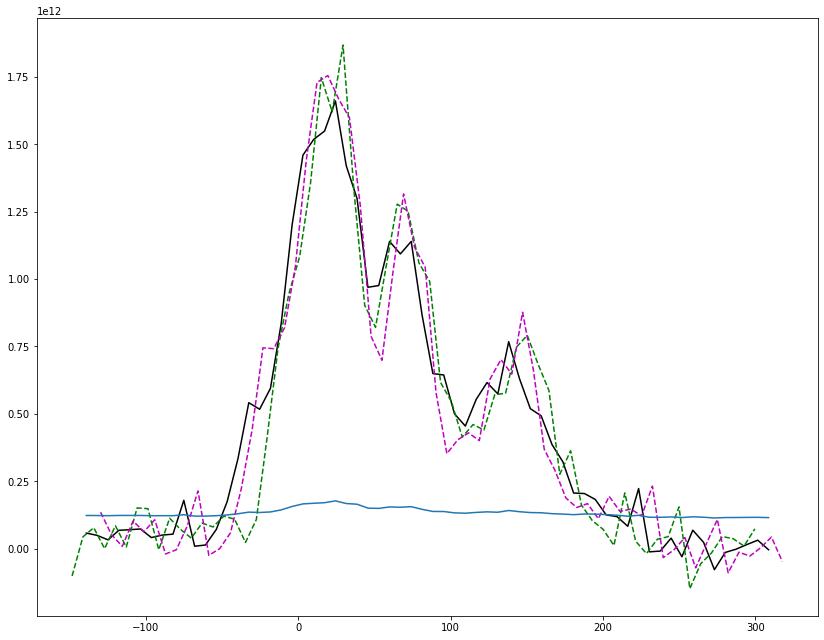

In [14]:
plt.plot(v, N_avg, 'k-')
plt.plot(v1, N1, '--g')
plt.plot(v2, N2, '--m')
plt.plot(v, Ne)